## FER2013
FER2013数据集由48x48像素的灰度人脸图像组成。这些人脸图像已经经过自动对齐处理，因此每张图中的人脸大致居中，并且在图像中所占的空间基本相同。

任务是根据人脸表情中显示的情绪，将每张人脸分类到七种情绪类别之一（0=愤怒，1=厌恶，2=恐惧，3=高兴，4=悲伤，5=惊讶，6=中性）。训练集包含28,709个样本，公开测试集包含3,589个样本。

数据集地址：https://www.kaggle.com/datasets/msambare/fer2013

## ⚙️ 参数与环境配置

本节配置了训练所需的参数与环境，适用于在 Jupyter Notebook 中直接运行。我们使用 `argparse.Namespace` 来模拟命令行参数输入，这在 Notebook 中比使用 `argparse.ArgumentParser` 更加方便。

### 参数说明：
- `model_type`：模型类型，支持 `'simplecnn'` 和 `'resnet18'`。
- `image_size`：输入图像的尺寸，FER2013 数据集中默认为 `48`。
- `num_input_channels`：根据模型选择，预处理输入图像的通道数，灰度图像为 `1`，彩色图像为 `3`。
- `pretrained_path`：可选参数，用于指定预训练模型的路径。
- `use_tiny_dataset`：是否使用子集进行快速验证和调试。

### 其他配置：
- `device`：根据是否有 CUDA 支持自动选择运行设备（GPU 或 CPU）。
- `data_root`：数据集路径，默认指向本地 `./FER2013` 文件夹。
- `model_save_path`：模型训练完成后的保存路径。
- `log_dir`：用于 TensorBoard 的日志保存目录。
- `use_tiny_dataset`：控制是否使用小数据集加快测试速度，正式训练时应设为 `False`。

In [1]:
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
import argparse
from sklearn.metrics import confusion_matrix

args = argparse.Namespace(
    model_type='resnet18',
    image_size=224,
    num_input_channels=3,
    pretrained_path='pretrained/resnet18-f37072fd.pth',
    use_tiny_dataset=False  # or False
)

# -----------------------------
# 配置
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = './FER2013'
model_save_path = f'./checkpoints/{args.model_type}_fer2013.pth'
log_dir = f'./logs/fer2013_{args.model_type}'
use_tiny_dataset = False # 默认False，使用True用来在子数据集上进行快速验证

2025-06-09 15:42:12.178650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 15:42:12.232496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 15:42:13.235917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 🧹 数据预处理与加载

本节定义了图像数据的预处理操作与数据加载方式，适用于 FER2013 情感识别数据集。

### 数据预处理流程：
- `Grayscale`：将图像转换为灰度图，通道数设为 1（适配 SimpleCNN）。
- `ToTensor`：将图像转换为张量格式。
- `Normalize`：将像素值标准化到 [-1, 1] 区间，使用均值 `0.5` 和标准差 `0.5`。

### 数据集加载：
- 使用 `ImageFolder` 从 `train` 和 `test` 文件夹中加载图像数据。
- 如果设置了 `use_tiny_dataset=True`，则从训练和验证集中各随机抽取 1000 个样本用于快速测试与调试。

### 数据加载器：
- `train_loader`：训练集加载器，启用 shuffle 和多线程（2个 worker）。
- `val_loader`：验证集加载器，禁用 shuffle，用于评估模型性能。

In [2]:
# -----------------------------
# 数据预处理与加载
# -----------------------------
transform = transforms.Compose([
        transforms.Resize((args.image_size, args.image_size)),
        transforms.Grayscale(num_output_channels=args.num_input_channels),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * args.num_input_channels, std=[0.5] * args.num_input_channels)
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'test'), transform=transform)


if use_tiny_dataset:
    # 使用小数据集进行测试
    train_dataset = torch.utils.data.Subset(train_dataset, random.sample(range(len(train_dataset)), 1000))
    val_dataset = torch.utils.data.Subset(val_dataset, random.sample(range(len(val_dataset)), 1000))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

## 🖼️ 类别样例图展示

本节用于从训练数据集中各类别中各选取一张图像进行可视化，帮助理解 FER2013 数据集中的不同情绪类别。

### 实现细节：
- 使用 `emotion_labels` 字典将类别索引映射为情绪名称（如 "Angry"、"Happy" 等）。
- `show_examples_per_class` 函数会遍历数据集，为每个类别选择第一张未展示的样本图像。
- 每张图像使用 `matplotlib` 显示，灰度模式渲染，标题显示对应情绪类别。

### 输出：
- 展示 7 张图像，每张对应一个情绪类别，有助于对数据分布有直观认识。

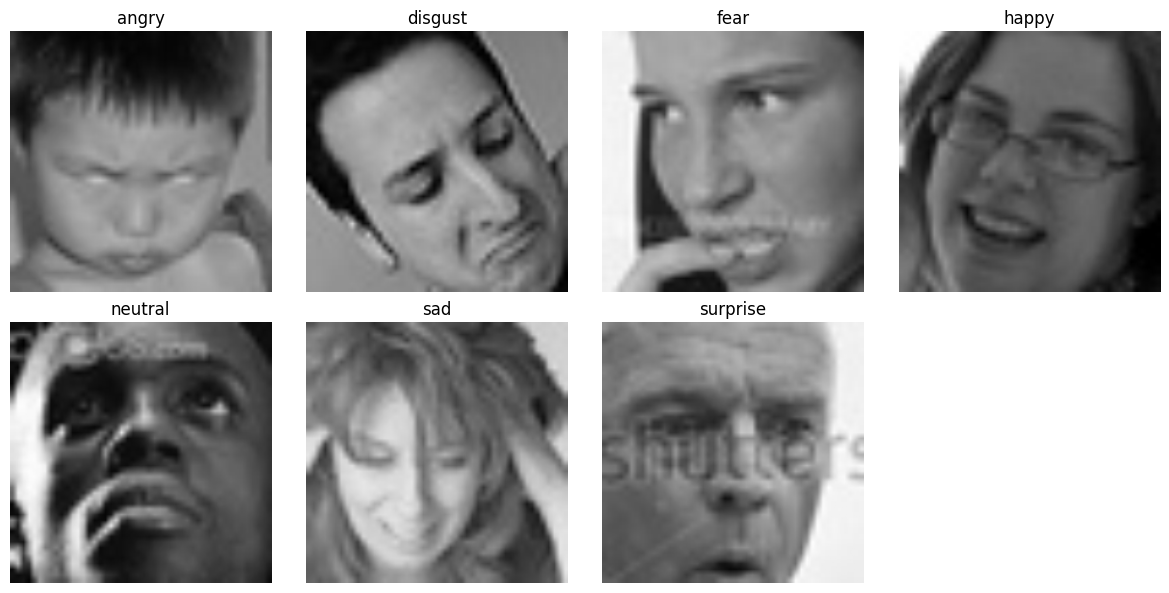

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
import os

# Emotion labels
# Emotion labels based on ImageFolder alphabetical indexing
emotion_labels = {
    0: "angry",     # angry
    1: "disgust",   # disgust
    2: "fear",      # fear
    3: "happy",     # happy
    4: "neutral",   # neutral
    5: "sad",       # sad
    6: "surprise"   # surprise
}

# 显示每个类别的一张样本图像
def show_examples_per_class(dataset, num_classes=7):
    shown = [False] * num_classes
    plt.figure(figsize=(12, 6))
    count = 0

    for img, label in dataset:
        if not shown[label]:
            img = img.permute(1, 2, 0).numpy()*0.5+0.5  # 将 (C, H, W) 转换为 (H, W, C)
            # print("img", img.max(), img.min(), img.mean())
            plt.subplot(2, 4, label + 1)
            plt.imshow(img)
            plt.title(emotion_labels[label])
            plt.axis('off')
            shown[label] = True
            count += 1
        if count == num_classes:
            break
    plt.tight_layout()
    plt.show()
    
show_examples_per_class(train_dataset)

## 📈 训练过程可视化函数

本函数 `plot_metrics` 用于绘制模型训练与验证过程中的准确率与损失曲线，并将结果保存为图片：

- **输入参数**：
  - `log_dir`：保存图像的文件夹路径
  - `train_accuracies` / `val_accuracies`：训练与验证准确率序列
  - `train_losses` / `val_losses`：训练与验证损失值序列

- **功能**：
  - 绘制并保存两张图：
    - **准确率曲线图**（accuracy_plot.png）
    - **损失曲线图**（loss_plot.png）

用于分析模型在每轮训练过程中的性能变化。

In [4]:
# -----------------------------
# 可视化函数
# -----------------------------
def plot_metrics(log_dir, train_accuracies, val_accuracies, train_losses, val_losses):
    """绘制训练和验证的准确率和损失曲线，并保存到指定目录
    Args:
        log_dir (str): 日志目录，用于保存图像
        train_accuracies (list): 训练准确率列表
        val_accuracies (list): 验证准确率列表
        train_losses (list): 训练损失列表
        val_losses (list): 验证损失列表 
    """
    plt.figure()
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{log_dir}/accuracy_plot.png")
    plt.close()

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{log_dir}/loss_plot.png")
    plt.close()


## 模型评估函数

该函数在验证集上评估模型的准确率与损失，并返回混淆矩阵。

- 模型设为评估模式（`model.eval()`）。
- 遍历验证数据集，计算损失与预测结果。
- 使用 `sklearn.metrics.confusion_matrix` 生成混淆矩阵。
- 返回验证准确率、平均损失和混淆矩阵。

In [5]:
def evaluate_model(model, val_loader, criterion, device):
    """评估模型在验证集上的性能
    Args:
        model (nn.Module): 训练好的模型
        val_loader (DataLoader): 验证集数据加载器
        criterion (nn.Module): 损失函数
        device (torch.device): 设备（CPU或GPU）
    Returns:
        accuracy (float): 验证集准确率
        avg_loss (float): 平均损失
        cm (np.ndarray): 混淆矩阵
    """
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, avg_loss, cm

## 🏋️‍♀️ 模型训练函数：`train_model`

该函数用于训练模型并在验证集上评估性能，支持 TensorBoard 可视化与早停机制。

### 🔧 输入参数：
- `model`：待训练的神经网络模型
- `train_loader`：训练数据加载器
- `val_loader`：验证数据加载器
- `criterion`：损失函数（如 `nn.CrossEntropyLoss`）
- `optimizer`：优化器（如 `torch.optim.Adam`）
- `device`：运行设备（'cuda' 或 'cpu'）
- `log_dir`：TensorBoard 日志保存路径
- `model_save_path`：模型权重保存路径
- `num_epochs`：最大训练轮数（默认 30）
- `patience`：早停容忍轮数（默认 5）

### 📈 功能说明：
- 在每一轮训练中：
  - 执行前向传播、反向传播与优化
  - 记录训练损失与准确率
  - 在验证集上评估并记录性能
- 使用 TensorBoard 保存指标
- 每轮绘制准确率和损失图像
- 若验证集损失持续 `patience` 轮未改善，则触发早停
- 保存验证损失最低的模型权重

### 📤 输出：
无返回值，但保存训练过程中的日志、图像和最优模型参数。

用于完整训练流程的核心函数。

In [6]:
# -----------------------------
# 训练函数
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, device, log_dir, model_save_path, num_epochs=30, patience=5):
    """
    训练模型并在验证集上评估性能，使用TensorBoard记录训练过程
    Args:
        model (nn.Module): 训练的模型
        train_loader (DataLoader): 训练集数据加载器
        val_loader (DataLoader): 验证集数据加载器
        criterion (nn.Module): 损失函数
        optimizer (torch.optim.Optimizer): 优化器
        device (torch.device): 设备（CPU或GPU）
        log_dir (str): TensorBoard日志目录
        model_save_path (str): 模型保存路径
        num_epochs (int): 训练轮数
        patience (int): 早停策略的耐心值
    """
    writer = SummaryWriter(log_dir)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_acc, val_loss, cm = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} - "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        plot_metrics(log_dir, train_accuracies, val_accuracies, train_losses, val_losses)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print("Validation loss improved. Model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}. No improvement in {patience} epochs.")
                break

    writer.close()

In [7]:
# -----------------------------
# 主流程
# -----------------------------
if __name__ == "__main__":
    print("Starting training on FER-2013 at 224x224 resolution...")

    # 模型定义
    if args.model_type == 'simplecnn':
        model = SimpleCNN(num_classes=7).to(device)
    else:
        model_dict = {
            'resnet18': models.resnet18,
            'resnet34': models.resnet34,
            'resnet50': models.resnet50,
        }
        model_class = model_dict[args.model_type]
        if args.pretrained_path:
            print(f"Loading pretrained {args.model_type} from {args.pretrained_path}")
            # 先加载预训练模型
            pretrained_dict = torch.load(args.pretrained_path, map_location=device)
            
            # 创建新模型
            model = model_class(pretrained=False)
            model.load_state_dict(pretrained_dict, strict=False)

            # 修改输出层
            model.fc = nn.Linear(model.fc.in_features, 7)
        model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, device, log_dir, model_save_path, num_epochs=30, patience=5)

    print("Training finished.")

Starting training on FER-2013 at 224x224 resolution...
Loading pretrained resnet18 from pretrained/resnet18-f37072fd.pth


/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30] - Train Loss: 1.2139, Val Loss: 1.2291 - Train Acc: 53.94%, Val Acc: 54.22%
Validation loss improved. Model saved.
Epoch [2/30] - Train Loss: 1.0084, Val Loss: 1.1098 - Train Acc: 62.07%, Val Acc: 58.40%
Validation loss improved. Model saved.
Epoch [3/30] - Train Loss: 0.8863, Val Loss: 1.0478 - Train Acc: 66.70%, Val Acc: 62.13%
Validation loss improved. Model saved.
Epoch [4/30] - Train Loss: 0.7687, Val Loss: 1.0606 - Train Acc: 71.25%, Val Acc: 61.66%
Epoch [5/30] - Train Loss: 0.6212, Val Loss: 1.1192 - Train Acc: 77.16%, Val Acc: 62.59%
Epoch [6/30] - Train Loss: 0.4510, Val Loss: 1.2198 - Train Acc: 83.60%, Val Acc: 64.54%
Epoch [7/30] - Train Loss: 0.3000, Val Loss: 1.3518 - Train Acc: 89.12%, Val Acc: 63.75%
Epoch [8/30] - Train Loss: 0.1976, Val Loss: 1.5118 - Train Acc: 93.13%, Val Acc: 63.62%
Early stopping at epoch 8. No improvement in 5 epochs.
Training finished.


## 显示训练过程中的损失和精度曲线

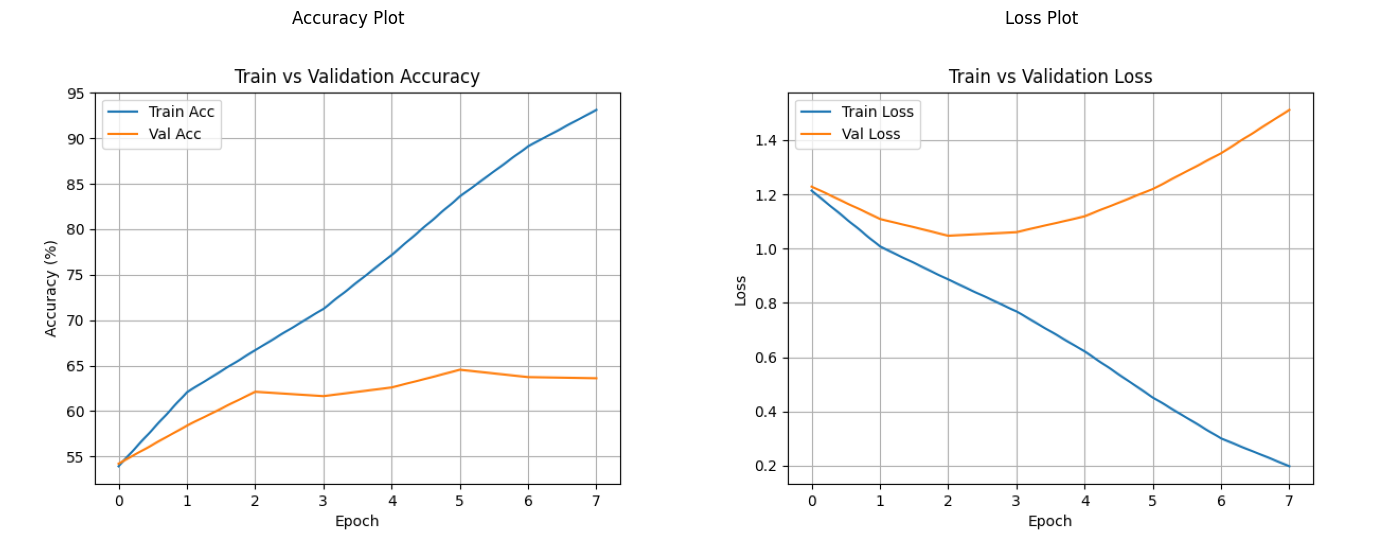

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image paths
accuracy_plot_path = f"{log_dir}/accuracy_plot.png"
loss_plot_path = f"{log_dir}/loss_plot.png"

# Load images
accuracy_img = mpimg.imread(accuracy_plot_path)
loss_img = mpimg.imread(loss_plot_path)

# Create a figure to display both plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Display the accuracy plot
axes[0].imshow(accuracy_img)
axes[0].axis('off')
axes[0].set_title('Accuracy Plot')

# Display the loss plot
axes[1].imshow(loss_img)
axes[1].axis('off')
axes[1].set_title('Loss Plot')

plt.tight_layout()
# plt.show()

## 显示混淆矩阵

Final Validation Accuracy: 62.13%, Final Validation Loss: 1.0478
Confusion Matrix:
[[ 682    8   99   29   68   60   12]
 [  64   26   11    2    3    4    1]
 [ 199    2  467   33   77  167   79]
 [  91    1   65 1471   57   66   23]
 [ 240    2   96   60  656  170    9]
 [ 281    0  196   28  151  582    9]
 [  37    1  125   55   29    8  576]]
Confusion matrix saved to ./logs/fer2013_resnet18/confusion_matrix.png


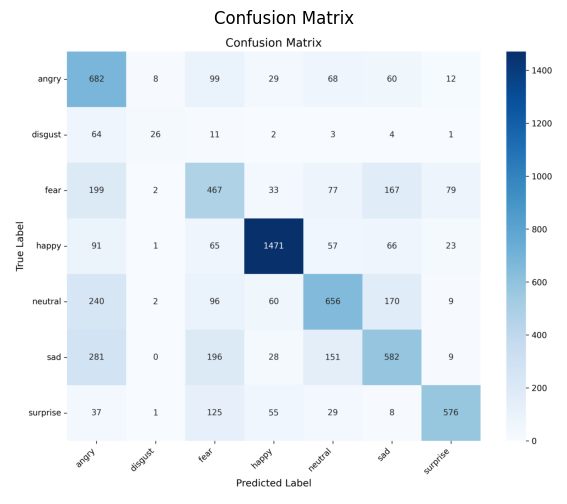

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Custom emotion labels
emotion_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise"
}

# Load and evaluate model
model.load_state_dict(torch.load(model_save_path))
val_acc, val_loss, cm = evaluate_model(model, val_loader, criterion, device)
print(f"Final Validation Accuracy: {val_acc:.2f}%, Final Validation Loss: {val_loss:.4f}")
print("Confusion Matrix:")
print(cm)

# Create a more detailed confusion matrix plot
plt.figure(figsize=(10, 8))

# Use seaborn for better visualization
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=emotion_labels.values(), 
                 yticklabels=emotion_labels.values(),
                 cbar=True)

# Add labels and title
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout
plt.tight_layout()

# Save the figure
confusionmatrix_plot_path = f"{log_dir}/confusion_matrix.png"
plt.savefig(confusionmatrix_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Confusion matrix saved to {confusionmatrix_plot_path}")

# Display the saved image
plt.figure(figsize=(8, 6))
img = plt.imread(confusionmatrix_plot_path)
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()